<h2>Assignment3</h2> - mini term project
<h3>Using Camera to detect Heartbeat</h3>
- 2017572003 Jaeyung Lee
- 2017572026 Juyeon Moon

In [53]:
# Load all library
import os
import skvideo.io
import skvideo.datasets
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
import collections

# Brightness signal computation

In [105]:
def brightness_signal(foldername):
    bright_d = collections.OrderedDict()
    fig = plt.figure(figsize=(20,15))
    for index, j in enumerate(os.listdir(foldername)):
        videodata = skvideo.io.vread(foldername+"\\"+j, outputdict={"-pix_fmt": "gray"})
        brightness = np.zeros((len(videodata)))
        for i in range(len(videodata)):
            frame = videodata[i]
            brightness[i] = sum(frame) / (frame.shape[0] * frame.shape[1])

        '''
        cutting 40 seconds ==> 40 seconds * 30fpb = 1200
        '''
        brightness = brightness[-1200:]
        bright_d[j] = brightness
        ax1 = fig.add_subplot(4,1,index+1)
        # plt.figure(figsize=(20,5))
        ax1.plot(list(range(len(brightness))), brightness)
        plt.title(j)
        
    plt.show()
    return bright_d

* Jaeyung's normal heartbeat brightness signal<br>
* Juyeon's normal & exercise heartbeat brightness signal

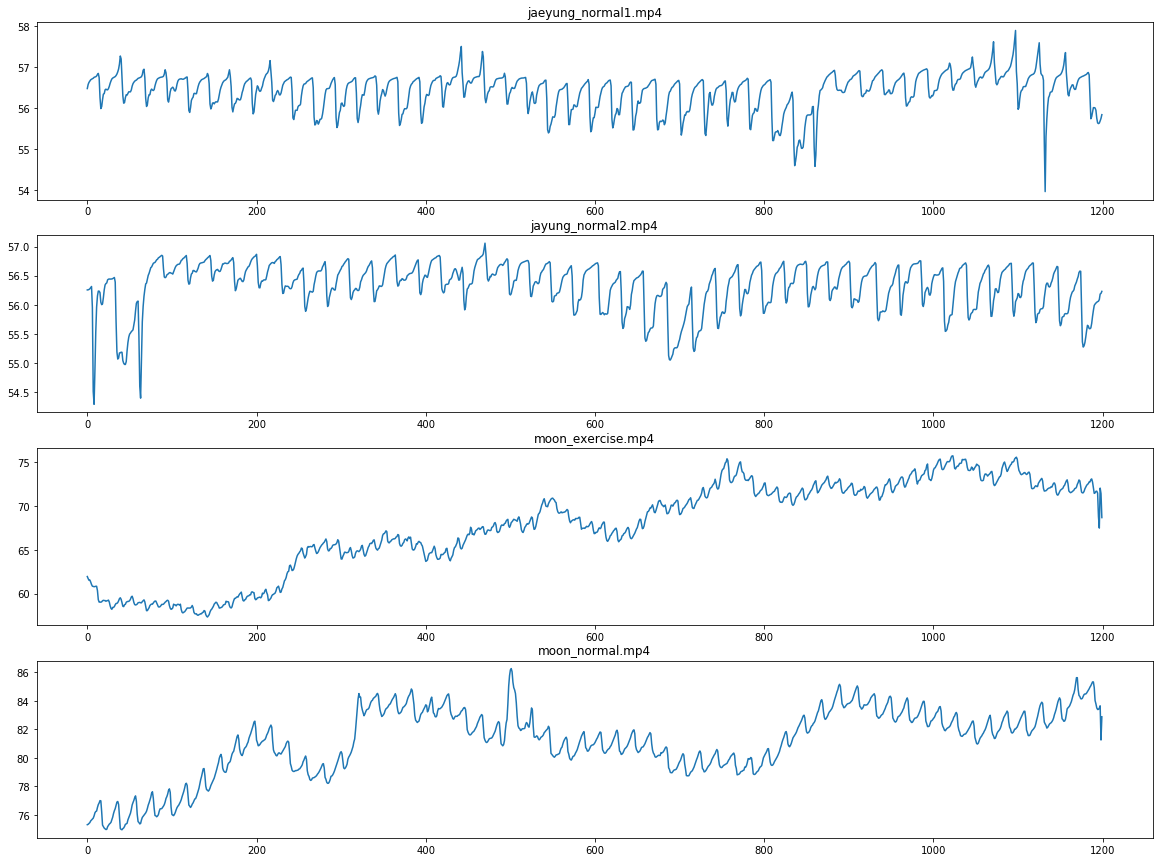

In [111]:
#just input your folder name
all_bright = brightness_signal("beat")

# Band-pass filtering
- I think my first video is nice. So, i use it:)

In [120]:
def Bandpass_filter(dict):
    BPM_L = 45;    # Heart rate lower limit [bpm]
    BPM_H = 200;   # Heart rate higher limit [bpm]
    frame_rate = 30
    fig = plt.figure(figsize=(20,15))
    band = collections.OrderedDict()

    # Butterworth frequencies must be in [0, 1], where 1 corresponds to half the sampling rate
    b, a = signal.butter(4, [((BPM_L / 60) / frame_rate * 2), ((BPM_H / 60) / frame_rate * 2)], 'bandpass')
    for index, data in enumerate(dict):
        filter_bright = signal.lfilter(b, a, dict[data])
        ax1 = fig.add_subplot(4,1,index+1)
        ax1.plot(list(range(len(filter_bright))), filter_bright)
        plt.title(data)
        band[data] = filter_bright
    plt.show()
    return band

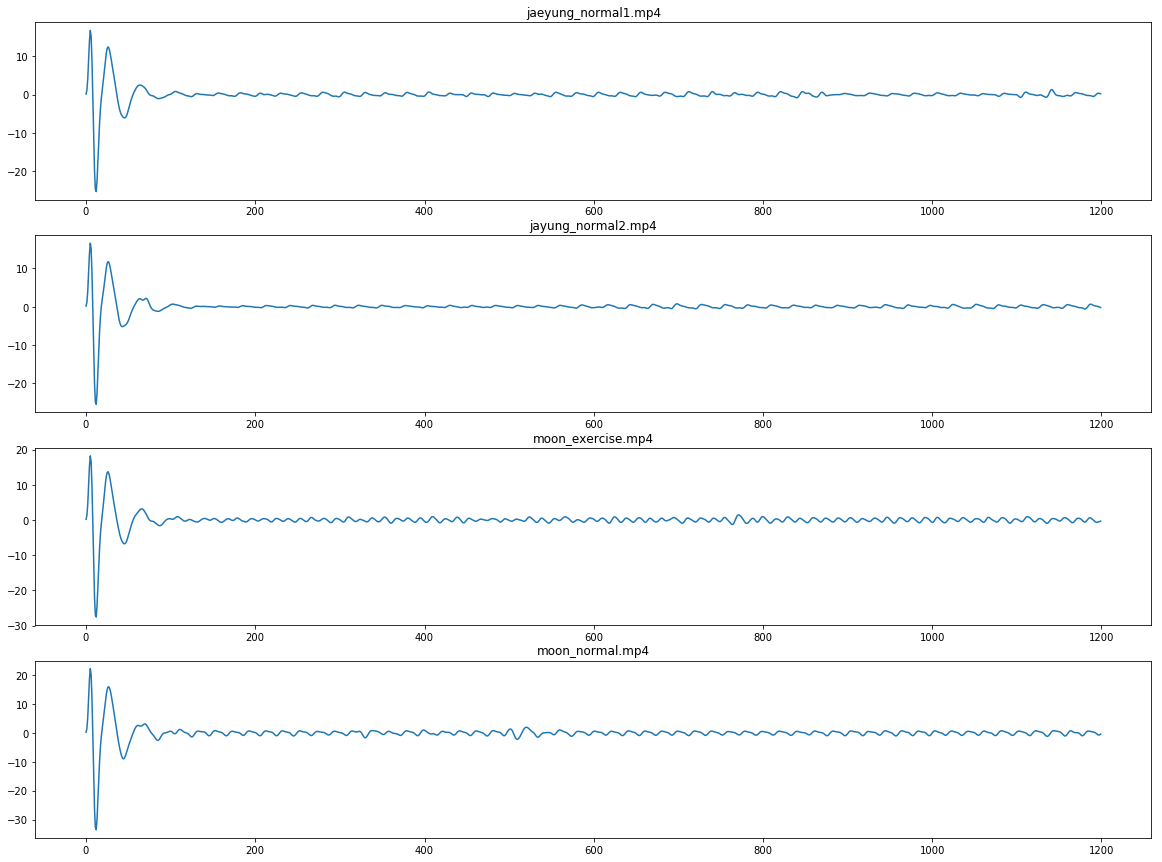

In [121]:
band = Bandpass_filter(all_bright)

# Smoothing 

In [122]:
def smoothing(dict):
    N = 5
    smooth = collections.OrderedDict()
    for index, data in enumerate(dict):
        smooth_signal = pd.rolling_mean(dict[data], N)[N-1:]
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(4,1,index+1)
        after, = plt.plot(list(range(len(smooth_signal))), smooth_signal, label="After smoothing")
        before, = plt.plot(list(range(len(filter_bright))), filter_bright, 'r', label="Before smoothing")
        plt.legend(handles=[after, before], fontsize="x-large")
        plt.show()
        smooth[data] = smooth_signal
    return smooth

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


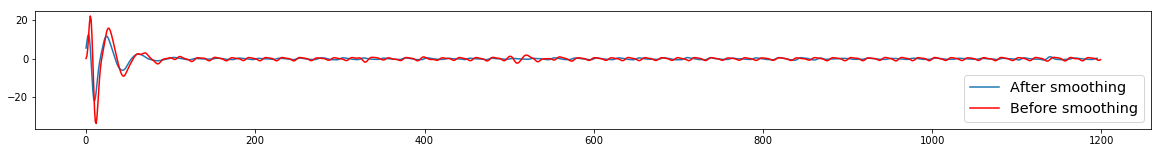

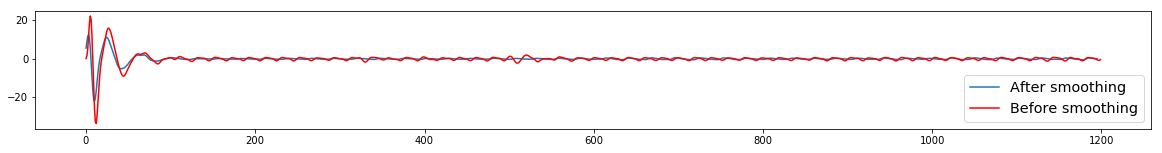

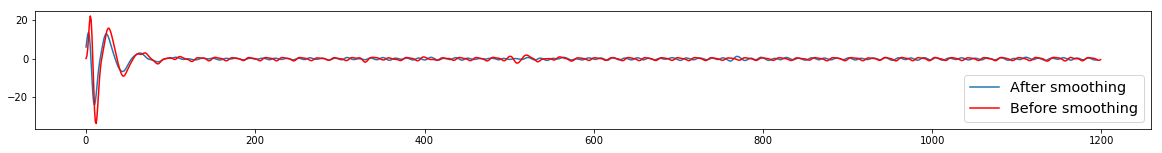

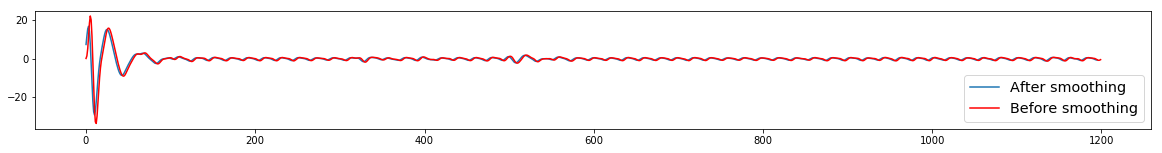

In [123]:
smooth = smoothing(band)

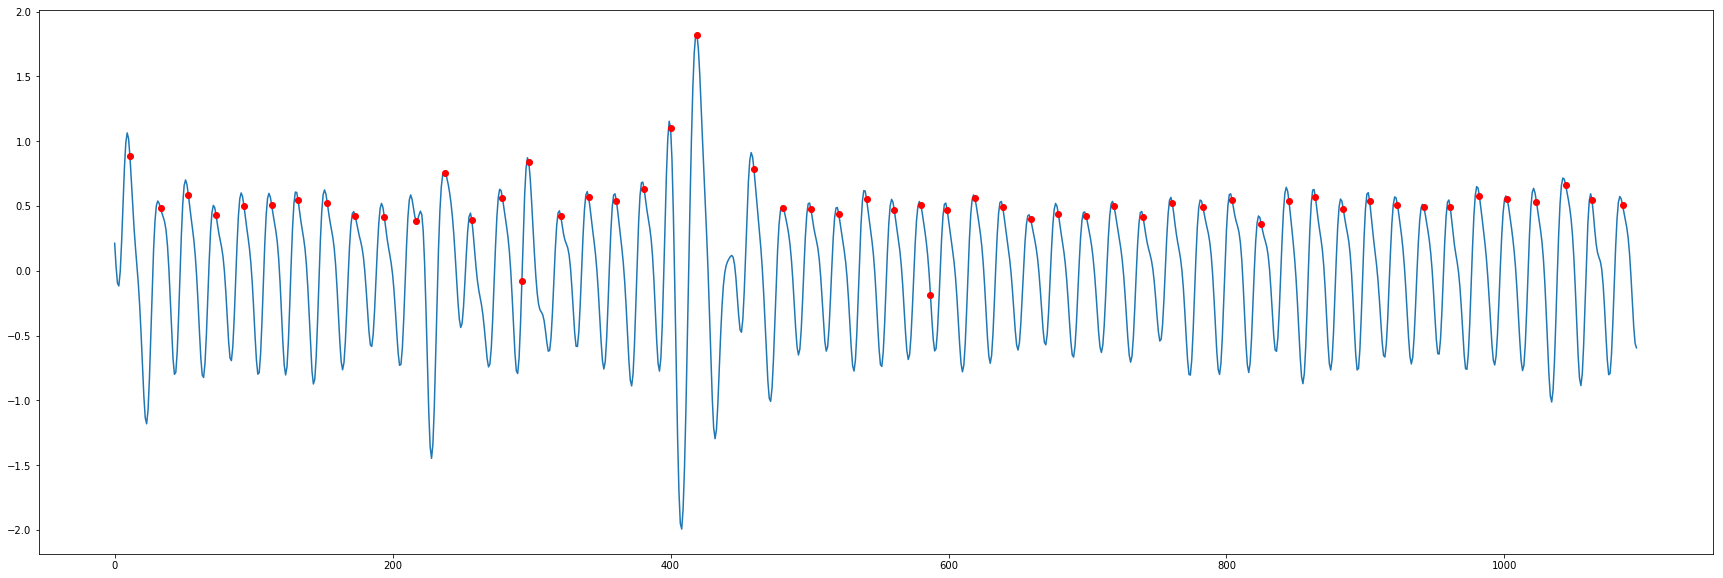

In [99]:
b_cutting = 100
peak = signal.find_peaks_cwt(smooth_signal[b_cutting:], np.arange(1,20))
peak_y = []

a_tck = smooth_signal[b_cutting:]
for i in peak:
    peak_y.append(a_tck[i])

plt.figure(figsize=(30,10))
plt.plot(list(range(len(smooth_signal[b_cutting:]))), smooth_signal[b_cutting:], peak, peak_y, 'ro')
plt.show()

# Upsampling & Interpolation

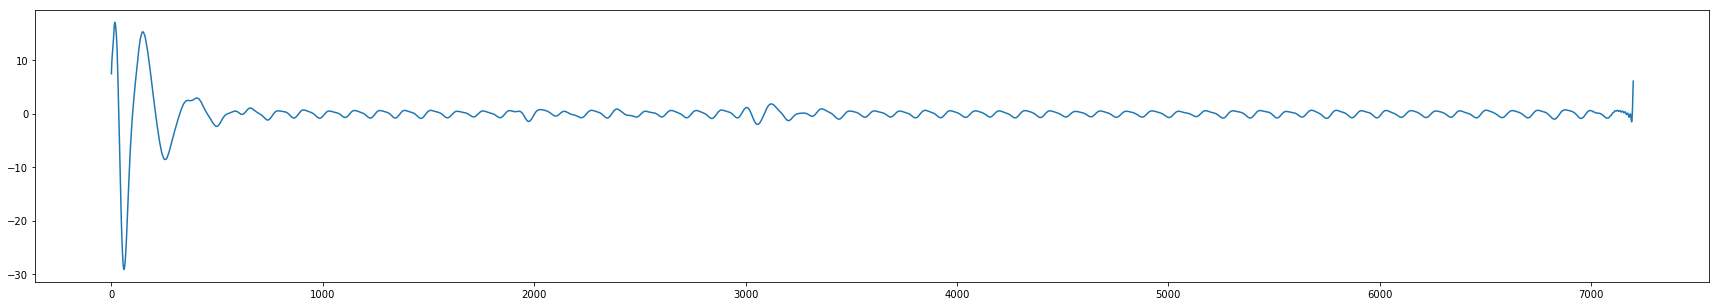

In [100]:
re_signal = signal.resample(smooth_signal, 1200 * 6)
plt.figure(figsize=(30,5))
plt.plot(list(range(len(re_signal[:]))), re_signal[:])
plt.show()

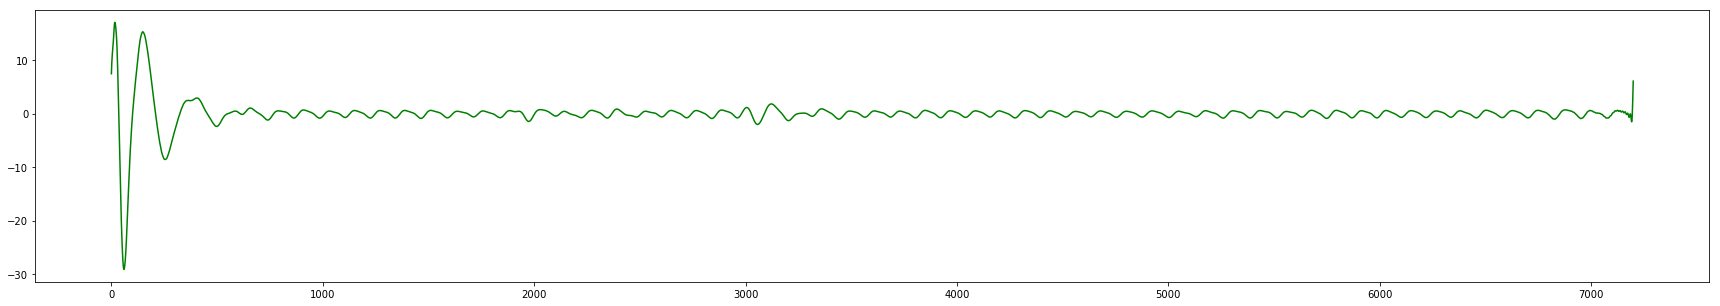

In [101]:
cubic = pd.Series(re_signal)
cubic.interpolate(method='cubic')

# print(len(cubic))
plt.figure(figsize=(30,5))
plt.plot(list(range(len(cubic))), cubic, 'g')
plt.show()


# Peak Detection

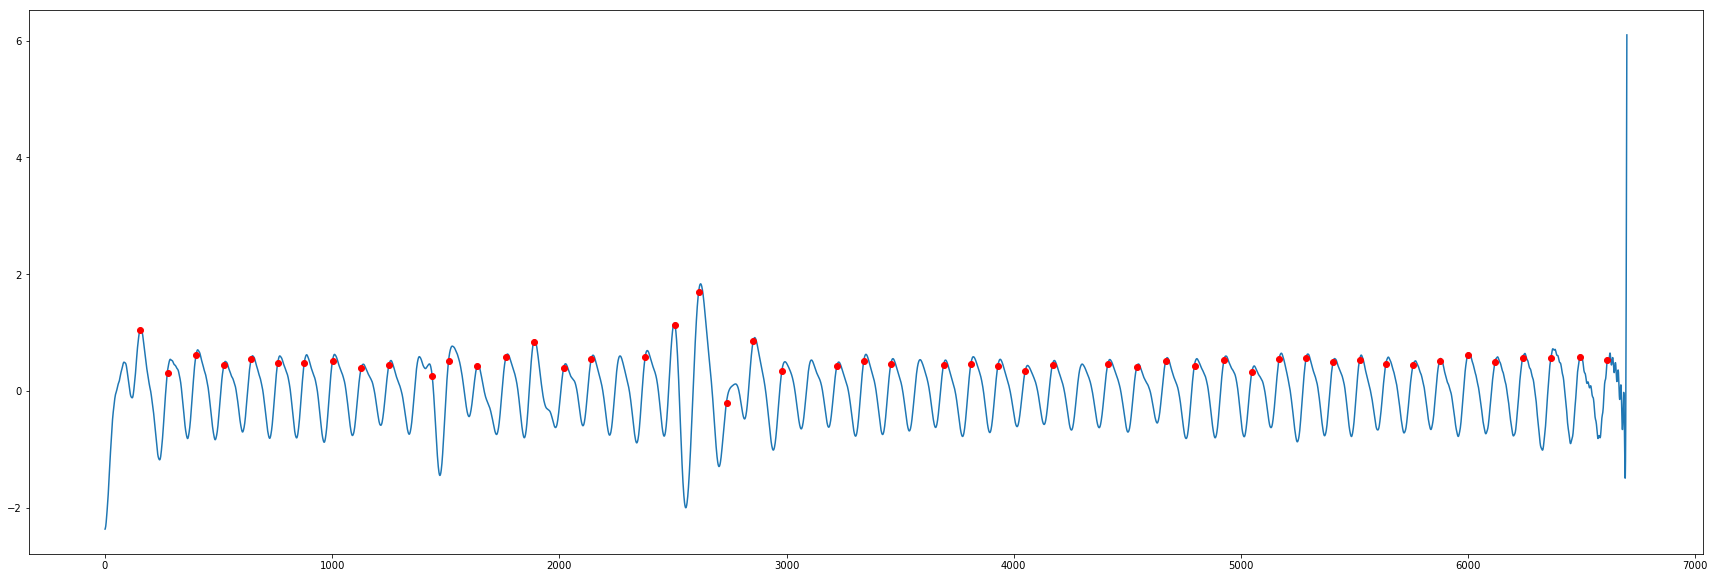

In [102]:
# print(len(tck[1][10:]))
cutting = 500
cubic = cubic[cutting:]
peak = signal.find_peaks_cwt(cubic, np.arange(1,100))
peak_y = []
# print(a_tck)
for i in peak:
    peak_y.append(cubic[i+499])

plt.figure(figsize=(30,10))
plt.plot(list(range(len(cubic))), cubic, peak, peak_y, 'ro')
plt.show()